In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from imports.data import CCV1
from torch_geometric.data import DataLoader 
from imports.models import Net_SEC, Net_GAT, Net_Trans
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from imports.Agglomerative import Aggloremative

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
import pandas as pd

df_GAT = pd.read_csv("csvMix/df_GAT_mix_015.csv")
df_SEC = pd.read_csv("csvMix/df_SEC_mix_021.csv")
df_Trans = pd.read_csv("csvMix/df_Trans_mix_0175.csv")
df_MT = pd.read_csv("csvMix/df_TICL_MT.csv")


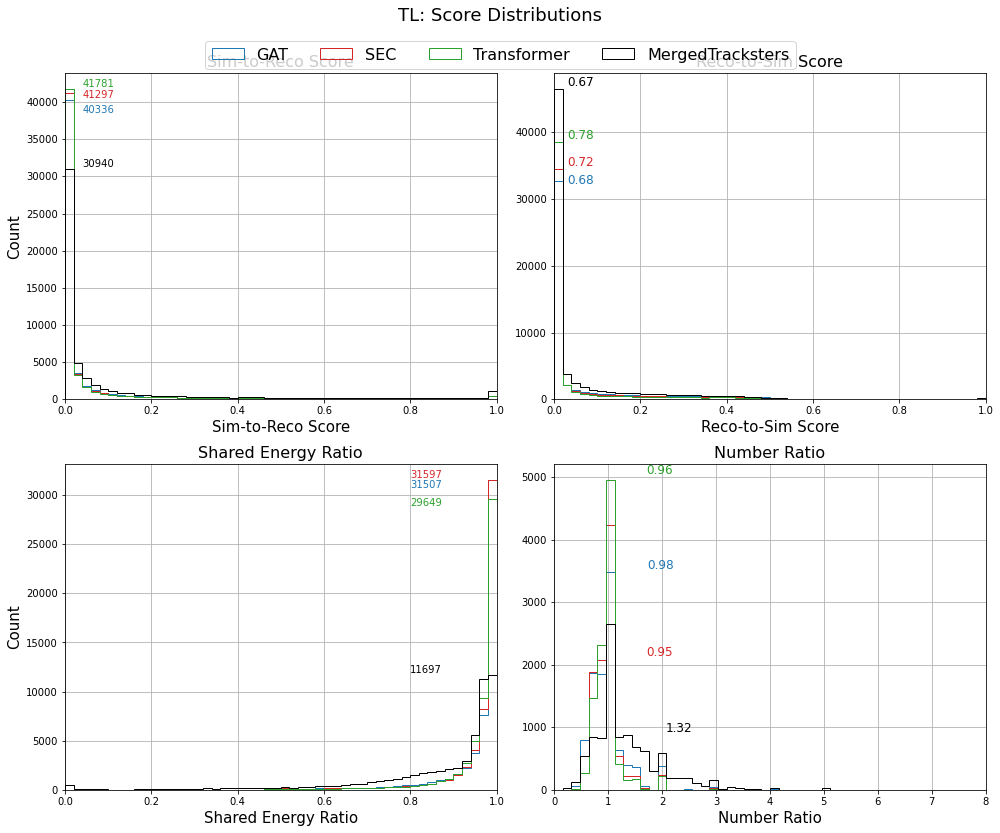

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Data Organization & Common Settings
# -------------------------------
# Assume your dataframes are already defined: df_GAT, df_SEC, df_Trans, df_MT.
dfs = {
    "GAT": df_GAT,
    "SEC": df_SEC,
    "Transformer": df_Trans,
    "MergedTracksters": df_MT,
}

colors = {
    "GAT": "tab:blue",
    "SEC": "tab:red",
    "Transformer": "tab:green",
    "MergedTracksters": "black"
}

bins_sim = np.linspace(0, 1, 51)

# -------------------------------
# 2. Process Sim-to-Reco Score
# -------------------------------
sim_to_reco_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "sim_to_reco_score"}
    if required_cols.issubset(df.columns):
        best_idx = df.groupby(["event_index", "cp_id"])["sim_to_reco_score"] \
                     .apply(lambda x: x.abs().idxmin())
        sim_to_reco_data[key] = df.loc[best_idx, "sim_to_reco_score"].values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

offsets_sim = {"GAT": -2000, "SEC": -1000, "Transformer": 0, "MergedTracksters": 30}
sim_x_offset = 0.03

# -------------------------------
# 3. Process Reco-to-Sim Score
# -------------------------------
reco_to_sim_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "trackster_id", "reco_to_sim_score"}
    if required_cols.issubset(df.columns):
        best_idx = df.groupby(["event_index", "trackster_id"])["reco_to_sim_score"] \
                     .apply(lambda x: x.abs().idxmin())
        reco_to_sim_data[key] = df.loc[best_idx, "reco_to_sim_score"].values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

offsets_reco = {"GAT": -1000, "SEC": 0, "Transformer": 0, "MergedTracksters": 30}
reco_x_offset = 0.02

# -------------------------------
# 4. Process Shared Energy Ratio
# -------------------------------
shared_energy_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "shared_energy", "cp_raw_energy"}
    if required_cols.issubset(df.columns):
        tmp = df.copy()
        tmp["energy_ratio"] = tmp["shared_energy"] / tmp["cp_raw_energy"]
        shared_energy_data[key] = tmp.groupby(["event_index", "cp_id"])["energy_ratio"].max().values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

global_max_e = max(np.max(v) for v in shared_energy_data.values() if len(v) > 0)
upper_bound_energy = max(1, global_max_e)
bins_shared = np.linspace(0, upper_bound_energy, 51)

energy_offsets = {"GAT": -1000, "SEC": 0, "Transformer": -900, "MergedTracksters": 10}
energy_x_offsets = {"GAT": 0.3, "SEC": 0.3, "Transformer": 0.3, "MergedTracksters": 0.3}

# -------------------------------
# 5. Process Number Ratio
# -------------------------------
ratio_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "trackster_id"}
    if required_cols.issubset(df.columns):
        ratios = df.groupby("event_index").apply(
            lambda sub: sub["trackster_id"].nunique() / sub["cp_id"].nunique()
            if sub["cp_id"].nunique() > 0 else np.nan
        ).dropna().values
        ratio_data[key] = ratios
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

global_max_r = max(np.max(v) for v in ratio_data.values() if len(v) > 0)
upper_bound_ratio = max(1, global_max_r)
bins_ratio = np.linspace(0, upper_bound_ratio, 51)

ratio_mean_offsets = {"GAT": 0, "SEC": 20, "Transformer": 40, "MergedTracksters": 10}
ratio_x_offsets = {k: 1 for k in dfs.keys()}

# -------------------------------
# 6. Annotation Helper Functions (unchanged)
# -------------------------------
def annotate_hist(ax, scores, bins_used, target_value, x_offset=0.0, y_offset=0.0, font_size=10, color="black"):
    counts, bins_local = np.histogram(scores, bins=bins_used, density=False)
    if target_value == 0:
        idx = 0
    elif target_value >= bins_used[-2]:
        idx = -1
    else:
        idx = np.searchsorted(bins_local, target_value) - 1
    x = (bins_local[idx] + bins_local[idx+1]) / 2 + x_offset
    y = counts[idx] + y_offset
    ax.text(x, y, str(counts[idx]), fontsize=font_size, ha='left', va='bottom', color=color)

def annotate_fraction(ax, scores, bins_used, target_value=0, x_offset=0.0, y_offset=0.0, font_size=12, color="black"):
    counts, bins_local = np.histogram(scores, bins=bins_used, density=False)
    total = counts.sum()
    idx = 0
    if total > 0:
        if target_value == 0:
            idx = 0
        elif target_value >= bins_used[-2]:
            idx = -1
        else:
            idx = np.searchsorted(bins_local, target_value) - 1
    frac = counts[idx] / total if total > 0 else 0
    x = (bins_local[idx] + bins_local[idx+1]) / 2 + x_offset
    y = counts[idx] + y_offset
    ax.text(x, y, f"{frac:.2f}", fontsize=font_size, ha='left', va='bottom', color=color)

def annotate_mean(ax, scores, bins_used, x_offset=0.0, y_offset=0.0, font_size=12, color="black"):
    mean_val = np.mean(scores)
    counts, bins_local = np.histogram(scores, bins=bins_used, density=False)
    idx = np.searchsorted(bins_local, mean_val) - 1
    idx = max(idx, 0)
    y = counts[idx]
    ax.text(mean_val + x_offset, y + y_offset, f"{mean_val:.2f}",
            fontsize=font_size, ha='center', va='bottom', color=color)

# -------------------------------
# 7. Plot All Four in a 2×2 Grid with Unified Styling
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top‑Left: Sim‑to‑Reco
axes[0, 0].set_title("Sim-to-Reco Score", fontsize=16)
for key, scores in sim_to_reco_data.items():
    axes[0, 0].hist(scores, bins=bins_sim, histtype='step', color=colors[key], label=key)
    annotate_hist(axes[0, 0], scores, bins_sim, 0,
                  x_offset=sim_x_offset, y_offset=offsets_sim[key], color=colors[key])
axes[0, 0].set_xlim(0, 1)
axes[0, 0].set_xlabel("Sim-to-Reco Score", fontsize=15)
axes[0, 0].set_ylabel("Count", fontsize=15)
axes[0, 0].grid(True)

# Top‑Right: Reco‑to‑Sim
axes[0, 1].set_title("Reco-to-Sim Score", fontsize=16)
for key, scores in reco_to_sim_data.items():
    axes[0, 1].hist(scores, bins=bins_sim, histtype='step', color=colors[key], label=key)
    annotate_fraction(axes[0, 1], scores, bins_sim, 0,
                      x_offset=reco_x_offset, y_offset=offsets_reco[key], color=colors[key])
axes[0, 1].set_xlim(0, 1)
axes[0, 1].set_xlabel("Reco-to-Sim Score", fontsize=15)
axes[0, 1].set_ylabel("", fontsize=15)
axes[0, 1].grid(True)

# Bottom‑Left: Shared Energy Ratio
axes[1, 0].set_title("Shared Energy Ratio", fontsize=16)
for key, scores in shared_energy_data.items():
    axes[1, 0].hist(scores, bins=bins_shared, histtype='step', color=colors[key], label=key)
    annotate_hist(axes[1, 0], scores, bins_shared, 1,
                  x_offset=energy_x_offsets[key], y_offset=energy_offsets[key], color=colors[key])
axes[1, 0].set_xlim(0, upper_bound_energy)
axes[1, 0].set_xlabel("Shared Energy Ratio", fontsize=15)
axes[1, 0].set_ylabel("Count", fontsize=15)
axes[1, 0].grid(True)

# Bottom‑Right: Number Ratio
axes[1, 1].set_title("Number Ratio", fontsize=16)
for key, scores in ratio_data.items():
    axes[1, 1].hist(scores, bins=bins_ratio, histtype='step', color=colors[key], label=key)
    annotate_mean(axes[1, 1], scores, bins_ratio,
                  x_offset=ratio_x_offsets[key], y_offset=ratio_mean_offsets[key], color=colors[key])
axes[1, 1].set_xlim(0, upper_bound_ratio)
axes[1, 1].set_xlabel("Number Ratio", fontsize=15)
axes[1, 1].set_ylabel("", fontsize=15)
axes[1, 1].grid(True)

# Overall title and legend
fig.suptitle("TL: Score Distributions", fontsize=18, y=0.96)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.93),
           ncol=len(labels), fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


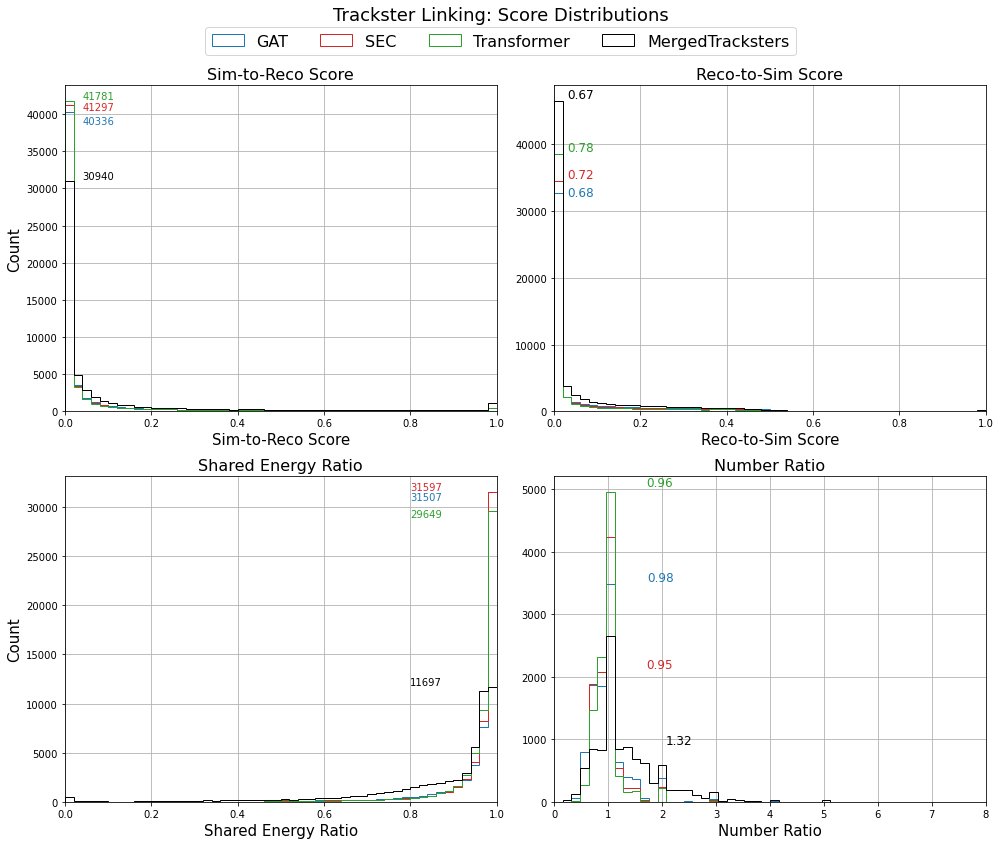

In [6]:
# -------------------------------
# 7. Plot All Four in a 2×2 Grid with Unified Styling
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top‑Left: Sim‑to‑Reco
axes[0, 0].set_title("Sim-to-Reco Score", fontsize=16)
for key, scores in sim_to_reco_data.items():
    axes[0, 0].hist(scores, bins=bins_sim, histtype='step', color=colors[key], label=key)
    annotate_hist(axes[0, 0], scores, bins_sim, 0,
                  x_offset=sim_x_offset, y_offset=offsets_sim[key], color=colors[key])
axes[0, 0].set_xlim(0, 1)
axes[0, 0].set_xlabel("Sim-to-Reco Score", fontsize=15)
axes[0, 0].set_ylabel("Count", fontsize=15)
axes[0, 0].grid(True)

# Top‑Right: Reco‑to‑Sim
axes[0, 1].set_title("Reco-to-Sim Score", fontsize=16)
for key, scores in reco_to_sim_data.items():
    axes[0, 1].hist(scores, bins=bins_sim, histtype='step', color=colors[key], label=key)
    annotate_fraction(axes[0, 1], scores, bins_sim, 0,
                      x_offset=reco_x_offset, y_offset=offsets_reco[key], color=colors[key])
axes[0, 1].set_xlim(0, 1)
axes[0, 1].set_xlabel("Reco-to-Sim Score", fontsize=15)
axes[0, 1].set_ylabel("", fontsize=15)
axes[0, 1].grid(True)

# Bottom‑Left: Shared Energy Ratio
axes[1, 0].set_title("Shared Energy Ratio", fontsize=16)
for key, scores in shared_energy_data.items():
    axes[1, 0].hist(scores, bins=bins_shared, histtype='step', color=colors[key], label=key)
    annotate_hist(axes[1, 0], scores, bins_shared, 1,
                  x_offset=energy_x_offsets[key], y_offset=energy_offsets[key], color=colors[key])
axes[1, 0].set_xlim(0, upper_bound_energy)
axes[1, 0].set_xlabel("Shared Energy Ratio", fontsize=15)
axes[1, 0].set_ylabel("Count", fontsize=15)
axes[1, 0].grid(True)

# Bottom‑Right: Number Ratio
axes[1, 1].set_title("Number Ratio", fontsize=16)
for key, scores in ratio_data.items():
    axes[1, 1].hist(scores, bins=bins_ratio, histtype='step', color=colors[key], label=key)
    annotate_mean(axes[1, 1], scores, bins_ratio,
                  x_offset=ratio_x_offsets[key], y_offset=ratio_mean_offsets[key], color=colors[key])
axes[1, 1].set_xlim(0, upper_bound_ratio)
axes[1, 1].set_xlabel("Number Ratio", fontsize=15)
axes[1, 1].set_ylabel("", fontsize=15)
axes[1, 1].grid(True)

# Overall title and legend
fig.suptitle("Trackster Linking: Score Distributions", fontsize=18, y=0.975)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96),
           ncol=len(labels), fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("TLScores.pdf")
plt.show()

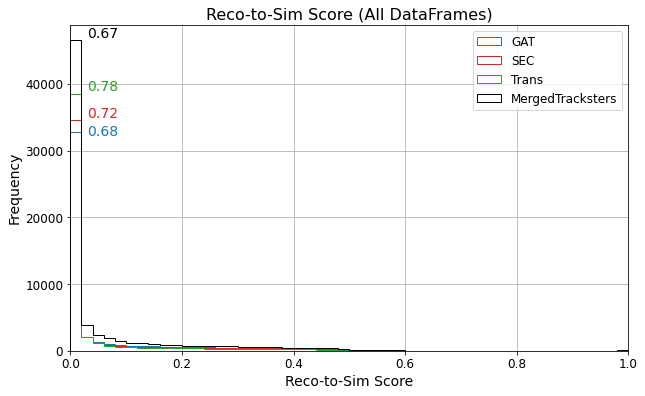

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Organize new dataframes into a dictionary with updated key for MT.
dfs = {
    "GAT": df_GAT,
    "SEC": df_SEC,
    "Trans": df_Trans,
    "MergedTracksters": df_MT,  # Updated key name.
}

# Fixed bins from 0 to 1 (50 bins) and color definitions.
bins_fixed = np.linspace(0, 1, 51)
colors = {
    "GAT": "tab:blue",
    "SEC": "tab:red",
    "Trans": "tab:green",
    "MergedTracksters": "black"
}

# --- 1. Process reco_to_sim_score ---
# For each dataframe, group by event_index and trackster_id and select
# the row with the reco_to_sim_score closest to zero.
reco_to_sim_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "trackster_id", "reco_to_sim_score"}
    if required_cols.issubset(df.columns):
        best_idx = df.groupby(["event_index", "trackster_id"])["reco_to_sim_score"].apply(lambda x: x.abs().idxmin())
        best_scores = df.loc[best_idx, "reco_to_sim_score"]
        reco_to_sim_data[key] = best_scores.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

# --- Annotation Helper (using fractions) ---
def annotate_fraction(ax, scores, target_value=0, x_offset=0.0, y_offset=0.0, font_size=14, color="black"):
    counts, bins = np.histogram(scores, bins=bins_fixed, density=False)
    total = np.sum(counts)
    if total == 0:
        frac = 0
        bin_index = 0
        x_loc = (bins[0] + bins[1]) / 2
    else:
        # Determine the bin index corresponding to the target value.
        if target_value == 0:
            bin_index = 0
            x_loc = (bins[0] + bins[1]) / 2
        elif target_value == 1:
            bin_index = -1
            x_loc = (bins[-2] + bins[-1]) / 2
        else:
            bin_index = np.searchsorted(bins, target_value) - 1
            x_loc = (bins[bin_index] + bins[bin_index+1]) / 2
        frac = counts[bin_index] / total
    x_loc += x_offset
    y_val = counts[bin_index] + y_offset
    text = f"{frac:.2f}"
    ax.text(x_loc, y_val, text, fontsize=font_size, ha='left', va='bottom', color=color)

# --- Define individual vertical offsets for each dataset ---
offsets = {
    "GAT": -1000,
    "SEC": 0,
    "Trans": 0,
    "MergedTracksters": 30
}

# --- 2. Plot reco_to_sim_score with fraction annotations on a single plot ---
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Reco-to-Sim Score (All DataFrames)", fontsize=16)

for key in reco_to_sim_data:
    scores = reco_to_sim_data[key]
    ax.hist(scores, bins=bins_fixed, histtype='step', density=False,
            color=colors[key], label=key)
    offset = offsets.get(key, 0)
    annotate_fraction(ax, scores, target_value=0, x_offset=0.02, y_offset=offset,
                      font_size=14, color=colors[key])

ax.set_xlabel("Reco-to-Sim Score", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlim(0, 1)
ax.legend(fontsize=12)
ax.grid(True)

plt.show()


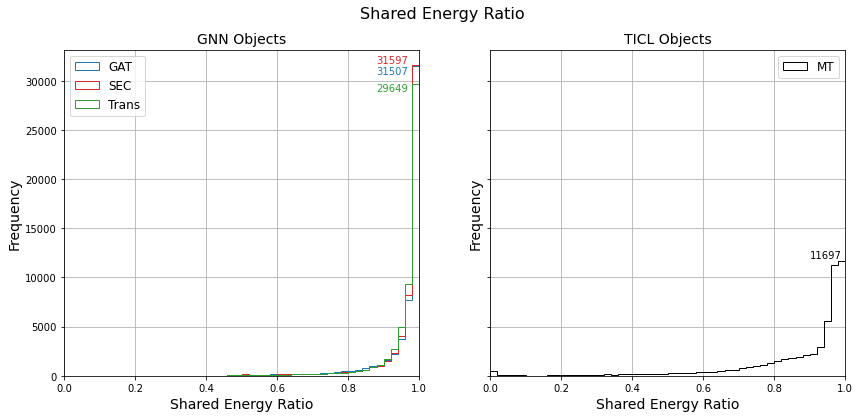

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Organize new dataframes into a dictionary.
dfs = {
    "GAT": df_GAT,
    "SEC": df_SEC,
    "Trans": df_Trans,
    "MT": df_MT,
}

# Define groups for plotting.
# Left subplot ("GNN Objects"): GAT, SEC, Trans.
# Right subplot ("TICL Objects"): MT.
left_group = ["GAT", "SEC", "Trans"]
right_group = ["MT"]

# --- 1. Process Shared Energy Ratio ---
# For each dataframe, compute the maximum of (shared_energy / cp_raw_energy)
# for each event and cp (grouped by "event_index" and "cp_id").
shared_energy_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "shared_energy", "cp_raw_energy"}
    if required_cols.issubset(df.columns):
        df_copy = df.copy()
        df_copy["energy_ratio"] = df_copy["shared_energy"] / df_copy["cp_raw_energy"]
        max_ratio = df_copy.groupby(["event_index", "cp_id"])["energy_ratio"].max()
        shared_energy_data[key] = max_ratio.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

# Determine the upper bound for binning.
global_max = max(np.max(r) for r in shared_energy_data.values() if len(r) > 0)
upper_bound = global_max if global_max > 1 else 1

# Define fixed bins from 0 to upper_bound with 50 bins.
bins_fixed = np.linspace(0, upper_bound, 51)

# --- 2. Annotation Helper (objective frequency) ---
# This function computes the histogram (using raw counts) of the scores and identifies
# the bin containing the target_value (here, we annotate the bin covering 1).
def annotate_hist(ax, scores, target_value, x_offset=0.0, y_offset=0.0, font_size=10, color="black"):
    counts, bins = np.histogram(scores, bins=bins_fixed, density=False)
    # Identify the appropriate bin.
    if target_value == 0:
        bin_index = 0
        x_loc = (bins[0] + bins[1]) / 2
    elif target_value >= bins_fixed[-2]:
        bin_index = -1
        x_loc = (bins[-2] + bins[-1]) / 2
    else:
        bin_index = np.searchsorted(bins, target_value) - 1
        x_loc = (bins[bin_index] + bins[bin_index+1]) / 2
    # Apply horizontal and vertical offsets.
    x_loc += x_offset
    y_val = counts[bin_index] + y_offset
    text = str(counts[bin_index])
    ax.text(x_loc, y_val, text, fontsize=font_size, ha='left', va='bottom', color=color)

# --- 3. Define individual vertical offsets for annotations ---
left_offsets = {
    "GAT": -1000,
    "SEC": 0,
    "Trans": -900
}
right_offsets = {
    "MT": 10
}

# Define colors for each model.
colors = {
    "GAT": "tab:blue",
    "SEC": "tab:red",
    "Trans": "tab:green",
    "MT": "black"
}

# --- 4. Plot Shared Energy Ratio ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

plt.suptitle("Shared Energy Ratio", fontsize=16, y=0.98)
axes[0].set_title("GNN Objects", fontsize=14)
axes[1].set_title("TICL Objects", fontsize=14)

# Plot histograms for the left group.
for key in left_group:
    if key in shared_energy_data:
        scores = shared_energy_data[key]
        axes[0].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = left_offsets.get(key, 0)
        annotate_hist(axes[0], scores, target_value=1, x_offset=-0.11, y_offset=offset,
                      font_size=10, color=colors[key])

# Plot histograms for the right group.
for key in right_group:
    if key in shared_energy_data:
        scores = shared_energy_data[key]
        axes[1].hist(scores, bins=bins_fixed, histtype='step', density=False,
                     color=colors[key], label=key)
        offset = right_offsets.get(key, 0)
        annotate_hist(axes[1], scores, target_value=1, x_offset=-0.09, y_offset=offset,
                      font_size=10, color=colors[key])

for ax in axes:
    ax.set_xlabel("Shared Energy Ratio", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_xlim(0, upper_bound)
    ax.legend(fontsize=12)
    ax.grid(True)

plt.subplots_adjust(top=0.88)
plt.show()


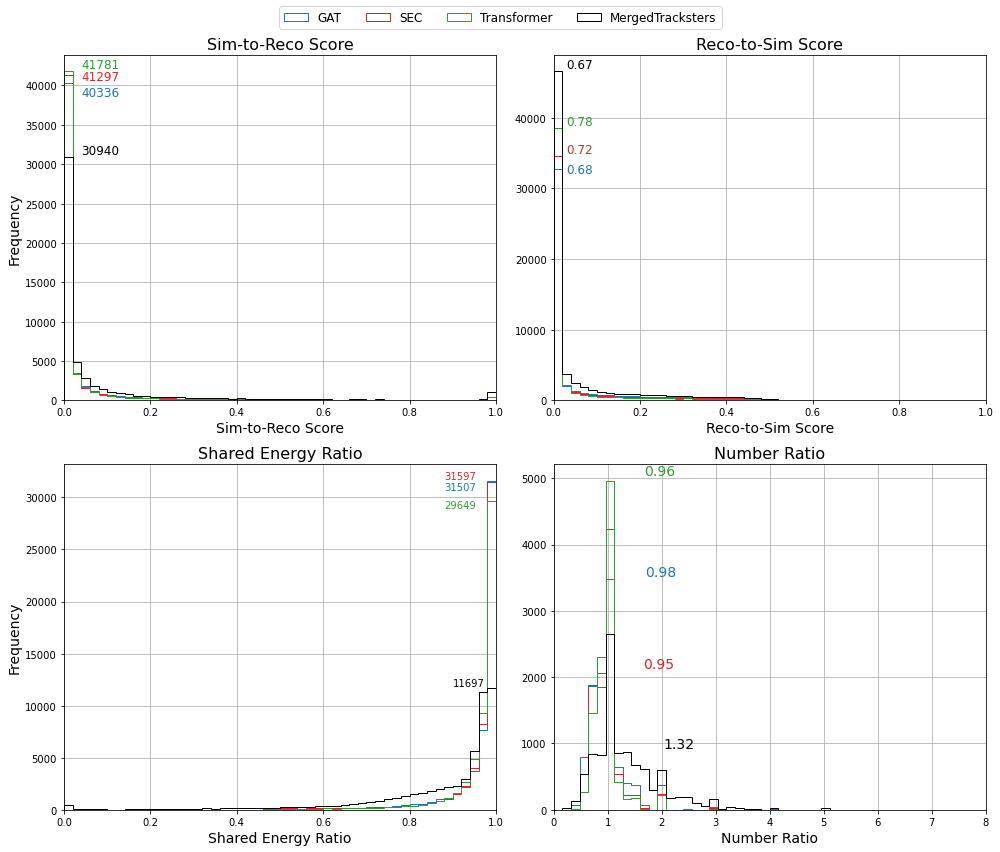

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Data Organization & Common Settings
# -------------------------------
# Assume your dataframes are already defined: df_GAT, df_SEC, df_Trans, df_MT.
# Use a common dictionary with unified keys.
dfs = {
    "GAT": df_GAT,
    "SEC": df_SEC,
    "Transformer": df_Trans,
    "MergedTracksters": df_MT,  # Updated key for MT
}

# Define a common colour mapping.
colors = {
    "GAT": "tab:blue",
    "SEC": "tab:red",
    "Transformer": "tab:green",
    "MergedTracksters": "black"
}

# For Sim-to-Reco and Reco-to-Sim, we use fixed bins from 0 to 1.
bins_sim = np.linspace(0, 1, 51)

# -------------------------------
# 2. Process Sim-to-Reco Score
# -------------------------------
sim_to_reco_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "sim_to_reco_score"}
    if required_cols.issubset(df.columns):
        # For each event and cp_id, select the row with sim_to_reco_score closest to 0.
        best_idx = df.groupby(["event_index", "cp_id"])["sim_to_reco_score"].apply(lambda x: x.abs().idxmin())
        best_scores = df.loc[best_idx, "sim_to_reco_score"]
        sim_to_reco_data[key] = best_scores.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

# Offsets for annotation (adjust if needed)
offsets_sim = {"GAT": -2000, "SEC": -1000, "Transformer": 0, "MergedTracksters": 30}
sim_x_offset = 0.03

# -------------------------------
# 3. Process Reco-to-Sim Score
# -------------------------------
reco_to_sim_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "trackster_id", "reco_to_sim_score"}
    if required_cols.issubset(df.columns):
        best_idx = df.groupby(["event_index", "trackster_id"])["reco_to_sim_score"].apply(lambda x: x.abs().idxmin())
        best_scores = df.loc[best_idx, "reco_to_sim_score"]
        reco_to_sim_data[key] = best_scores.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

offsets_reco = {"GAT": -1000, "SEC": 0, "Transformer": 0, "MergedTracksters": 30}
reco_x_offset = 0.02

# -------------------------------
# 4. Process Shared Energy Ratio
# -------------------------------
shared_energy_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "shared_energy", "cp_raw_energy"}
    if required_cols.issubset(df.columns):
        df_copy = df.copy()
        df_copy["energy_ratio"] = df_copy["shared_energy"] / df_copy["cp_raw_energy"]
        max_ratio = df_copy.groupby(["event_index", "cp_id"])["energy_ratio"].max()
        shared_energy_data[key] = max_ratio.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

# Determine upper bound for shared energy ratio bins.
global_max_energy = max(np.max(r) for r in shared_energy_data.values() if len(r) > 0)
upper_bound_energy = global_max_energy if global_max_energy > 1 else 1
bins_shared = np.linspace(0, upper_bound_energy, 51)

# Offsets for shared energy ratio annotation.
energy_offsets = {"GAT": -1000, "SEC": 0, "Transformer": -900, "MergedTracksters": 10}
energy_x_offsets = {"GAT": -0.11, "SEC": -0.11, "Transformer": -0.11, "MergedTracksters": -0.09}

# -------------------------------
# 5. Process Number Ratio
# -------------------------------
ratio_data = {}
for key, df in dfs.items():
    required_cols = {"event_index", "cp_id", "trackster_id"}
    if required_cols.issubset(df.columns):
        # For each event, compute (# unique trackster_id) / (# unique cp_id).
        ratios = df.groupby("event_index").apply(
            lambda subdf: subdf["trackster_id"].nunique() / subdf["cp_id"].nunique() 
            if subdf["cp_id"].nunique() > 0 else np.nan
        ).dropna()
        ratio_data[key] = ratios.values
    else:
        print(f"DataFrame '{key}' is missing required columns: {required_cols}")

global_max_ratio = max(np.max(r) for r in ratio_data.values() if len(r) > 0)
upper_bound_ratio = global_max_ratio if global_max_ratio > 1 else 1
bins_ratio = np.linspace(0, upper_bound_ratio, 51)

# Offsets for number ratio (mean annotation).
ratio_mean_offsets = {"GAT": 0, "SEC": 20, "Transformer": 40, "MergedTracksters": 10}
ratio_x_offsets = {"GAT": 1, "SEC": 1, "Transformer": 1, "MergedTracksters": 1}

# -------------------------------
# 6. Annotation Helper Functions
# -------------------------------
def annotate_hist(ax, scores, bins_used, target_value, x_offset=0.0, y_offset=0.0, font_size=10, color="black"):
    """Annotate the histogram with the raw count in the bin covering target_value."""
    counts, bins_local = np.histogram(scores, bins=bins_used, density=False)
    if target_value == 0:
        bin_index = 0
        x_loc = (bins_local[0] + bins_local[1]) / 2
    elif target_value >= bins_used[-2]:
        bin_index = -1
        x_loc = (bins_local[-2] + bins_local[-1]) / 2
    else:
        bin_index = np.searchsorted(bins_local, target_value) - 1
        x_loc = (bins_local[bin_index] + bins_local[bin_index+1]) / 2
    x_loc += x_offset
    y_val = counts[bin_index] + y_offset
    text = str(counts[bin_index])
    ax.text(x_loc, y_val, text, fontsize=font_size, ha='left', va='bottom', color=color)

def annotate_fraction(ax, scores, bins_used, target_value=0, x_offset=0.0, y_offset=0.0, font_size=14, color="black"):
    """Annotate the histogram with the fraction (count/total) of the bin covering target_value."""
    counts, bins_local = np.histogram(scores, bins=bins_used, density=False)
    total = counts.sum()
    if total == 0:
        frac = 0
        bin_index = 0
        x_loc = (bins_local[0] + bins_local[1]) / 2
    else:
        if target_value == 0:
            bin_index = 0
            x_loc = (bins_local[0] + bins_local[1]) / 2
        elif target_value >= bins_used[-2]:
            bin_index = -1
            x_loc = (bins_local[-2] + bins_local[-1]) / 2
        else:
            bin_index = np.searchsorted(bins_local, target_value) - 1
            x_loc = (bins_local[bin_index] + bins_local[bin_index+1]) / 2
        frac = counts[bin_index] / total
    x_loc += x_offset
    y_val = counts[bin_index] + y_offset
    text = f"{frac:.2f}"
    ax.text(x_loc, y_val, text, fontsize=font_size, ha='left', va='bottom', color=color)

def annotate_mean(ax, scores, bins_used, x_offset=0.0, y_offset=0.0, font_size=14, color="black"):
    """Annotate the histogram with the mean value of the scores."""
    mean_val = np.mean(scores)
    counts, bins_local = np.histogram(scores, bins=bins_used, density=False)
    bin_index = np.searchsorted(bins_local, mean_val) - 1
    if bin_index < 0:
        bin_index = 0
    y_val = counts[bin_index]
    ax.text(mean_val + x_offset, y_val + y_offset, f"{mean_val:.2f}",
            fontsize=font_size, ha='center', va='bottom', color=color)

# -------------------------------
# 7. Plot All Four in a 2×2 Grid with a Common Legend at the Top
# -------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top Left: Sim-to-Reco Score
axes[0, 0].set_title("Sim-to-Reco Score", fontsize=16)
for key, scores in sim_to_reco_data.items():
    axes[0, 0].hist(scores, bins=bins_sim, histtype='step', density=False,
                    color=colors[key], label=key)
    axes[0, 0].grid(True)
    annotate_hist(axes[0, 0], scores, bins_sim, target_value=0,
                  x_offset=sim_x_offset, y_offset=offsets_sim.get(key, 0),
                  font_size=12, color=colors[key])
axes[0, 0].set_xlabel("Sim-to-Reco Score", fontsize=14)
axes[0, 0].set_ylabel("Frequency", fontsize=14)
axes[0, 0].set_xlim(0, 1)

# Top Right: Reco-to-Sim Score
axes[0, 1].set_title("Reco-to-Sim Score", fontsize=16)
for key, scores in reco_to_sim_data.items():
    axes[0, 1].hist(scores, bins=bins_sim, histtype='step', density=False,
                    color=colors[key], label=key)
    axes[0, 1].grid(True)
    annotate_fraction(axes[0, 1], scores, bins_sim, target_value=0,
                      x_offset=reco_x_offset, y_offset=offsets_reco.get(key, 0),
                      font_size=12, color=colors[key])
axes[0, 1].set_xlabel("Reco-to-Sim Score", fontsize=14)
axes[0, 1].set_xlim(0, 1)

# Bottom Left: Shared Energy Ratio
axes[1, 0].set_title("Shared Energy Ratio", fontsize=16)
for key, scores in shared_energy_data.items():
    axes[1, 0].hist(scores, bins=bins_shared, histtype='step', density=False,
                    color=colors[key], label=key)
    axes[1, 0].grid(True)
    annotate_hist(axes[1, 0], scores, bins_shared, target_value=1,
                  x_offset=energy_x_offsets.get(key, 0), y_offset=energy_offsets.get(key, 0),
                  font_size=10, color=colors[key])
axes[1, 0].set_xlabel("Shared Energy Ratio", fontsize=14)
axes[1, 0].set_ylabel("Frequency", fontsize=14)
axes[1, 0].set_xlim(0, upper_bound_energy)

# Bottom Right: Number Ratio
axes[1, 1].set_title("Number Ratio", fontsize=16)
for key, scores in ratio_data.items():
    axes[1, 1].hist(scores, bins=bins_ratio, histtype='step', density=False,
                    color=colors[key], label=key)
    axes[1, 1].grid(True)
    annotate_mean(axes[1, 1], scores, bins_ratio,
                  x_offset=ratio_x_offsets.get(key, 0), y_offset=ratio_mean_offsets.get(key, 0),
                  font_size=14, color=colors[key])
axes[1, 1].set_xlabel("Number Ratio", fontsize=14)
axes[1, 1].set_xlim(0, upper_bound_ratio)

# Create a common legend from one of the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(), loc='upper center',
           bbox_to_anchor=(0.5, 0.99), ncol=len(unique), fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
